In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# HMC, SGMCMC and MFVI on Synthetic Regression

In [1]:
import os
import sys
from jax.config import config
import haiku as hk
import jax
from jax import numpy as jnp
import numpy as onp
import time
from jax.experimental.callback import rewrite
import tqdm
import copy

from bnn_hmc.utils import data_utils
from bnn_hmc.utils import models
from bnn_hmc.utils import losses
from bnn_hmc.utils import checkpoint_utils
from bnn_hmc.utils import cmd_args_utils
from bnn_hmc.utils import logging_utils
from bnn_hmc.utils import train_utils
from bnn_hmc.utils import tree_utils
from bnn_hmc.utils import precision_utils
from bnn_hmc.utils import optim_utils

import optax
import functools

from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# tpu_ip = "10.0.0.2"
# config.FLAGS.jax_xla_backend = "tpu_driver"
# config.FLAGS.jax_backend_target = "grpc://{}:8470".format(tpu_ip)
train_utils.set_up_jax(None, False)

## Data

In [3]:
data_npz = onp.load("synth_reg_data.npz")
x_ = jnp.asarray(data_npz["x_"])
y_ = jnp.asarray(data_npz["y_"])
f_ = jnp.asarray(data_npz["f_"])
x = jnp.asarray(data_npz["x"])
y = jnp.asarray(data_npz["y"])
f = jnp.asarray(data_npz["f"])

data_info = {"y_scale": 1.}

In [4]:
def inv_softplus(x):
    return jnp.log(jnp.exp(x) - 1)

# Noise in the data
noise_std = 0.02
invsp_noise_std = inv_softplus(noise_std)

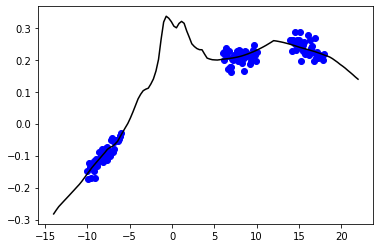

In [5]:
plt.plot(x, y, "bo")
plt.plot(x_, y_, "-k")

In [6]:
num_devices = len(jax.devices())
train_set = (f, y)
test_set = (f_, y_)
train_set = data_utils.pmap_dataset(train_set, num_devices)
test_set = data_utils.pmap_dataset(test_set, num_devices)

## Model

In [7]:
def make_model(layer_dims, invsp_noise_std):
    def forward(batch, is_training):
        x, _ = batch
        x = hk.Flatten()(x)
        for layer_dim in layer_dims:
            x = hk.Linear(layer_dim)(x)
            x = jax.nn.relu(x)
        x = hk.Linear(1)(x)
        x = jnp.concatenate([x, jnp.ones_like(x) * invsp_noise_std], -1)
        return x
    return forward

In [8]:
# net_fn = models.make_mlp_regression(data_info, output_dim=1, layer_dims=[100, 100, 100])
net_fn = make_model(layer_dims=[100, 100, 100], invsp_noise_std=invsp_noise_std)
net = hk.transform_with_state(net_fn)
net_apply, net_init = net.apply, net.init
net_apply = precision_utils.rewrite_high_precision(net_apply)

In [9]:
# key, net_init_key = jax.random.split(jax.random.PRNGKey(0), 2)
# start_iteration = 0
# num_ensembled = 0
# ensemble_predictions = None
# step_size = 1.e-4

In [10]:
def resample_params(seed, params, std=0.005):
    key = jax.random.PRNGKey(seed)
    num_leaves = len(jax.tree_leaves(params))
    normal_keys = list(jax.random.split(key, num_leaves))
    treedef = jax.tree_structure(params)
    normal_keys = jax.tree_unflatten(treedef, normal_keys)
    params = jax.tree_multimap(lambda p, k: jax.random.normal(k, p.shape) * std,
                               params, normal_keys)
    return params

In [11]:
param_seed = 2
params, net_state = net.init(jax.random.PRNGKey(param_seed), (f, None), True)
params = resample_params(param_seed, params)
net_state = jax.pmap(lambda _: net_state)(jnp.arange(num_devices))

## Prior and likelihood

In [12]:
prior_std = 0.1
weight_decay = 1 / prior_std**2

task = data_utils.Task("regression")
(likelihood_factory, predict_fn, ensemble_upd_fn, _,_) = train_utils.get_task_specific_fns(task, data_info)
log_prior_fn, log_prior_diff_fn = losses.make_gaussian_log_prior(weight_decay, 1.)

In [13]:
log_prior_fn, log_prior_diff_fn = (
    losses.make_gaussian_log_prior(weight_decay, 1.))
log_likelihood_fn = losses.make_gaussian_likelihood(1.)

## HMC
### HMC update

In [14]:
step_size = 1e-5
trajectory_len = jnp.pi / 2 / jnp.sqrt(weight_decay)
max_num_leapfrog_steps = int(trajectory_len // step_size + 1)
print("Leapfrog steps per iteration:", max_num_leapfrog_steps)

Leapfrog steps per iteration: 15708


In [15]:
update, get_log_prob_and_grad = train_utils.make_hmc_update(
    net_apply, log_likelihood_fn, log_prior_fn, log_prior_diff_fn,
    max_num_leapfrog_steps, 1., 0.)

In [16]:
# Initial log-prob and grad values
log_prob, state_grad, log_likelihood, net_state = (
    get_log_prob_and_grad(train_set, params, net_state))

### Run HMC

In [17]:
num_iterations = 100
all_test_preds = []
key = jax.random.PRNGKey(0)

for iteration in tqdm.tqdm(range(num_iterations)):
    
#     in_burnin = (iteration < args.num_burn_in_iterations)
#     do_mh_correction = (not args.no_mh) and (not in_burnin)

    (params, net_state, log_likelihood, state_grad, step_size, key,
     accept_prob, accepted) = (
        update(train_set, params, net_state, log_likelihood, state_grad,
               key, step_size, trajectory_len, True))
    # Evaluation
    test_predictions = onp.asarray(
      predict_fn(net_apply, params, net_state, test_set))
    if accepted:
        all_test_preds.append(test_predictions)

    print("It: {} \t Accept P: {} \t Accepted {} \t Log-likelihood: {}".format(
            iteration, accept_prob, accepted, log_likelihood))

  0%|          | 0/100 [00:00<?, ?it/s]/home/pavel/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
  1%|          | 1/100 [00:04<08:14,  4.99s/it]

It: 0 	 Accept P: 0.44331416487693787 	 Accepted False 	 Log-likelihood: -4750.1806640625


  2%|▏         | 2/100 [00:09<07:40,  4.70s/it]

It: 1 	 Accept P: 0.6106910705566406 	 Accepted True 	 Log-likelihood: 288.75006103515625


  3%|▎         | 3/100 [00:13<07:25,  4.59s/it]

It: 2 	 Accept P: 0.6960702538490295 	 Accepted False 	 Log-likelihood: 288.75006103515625


  4%|▍         | 4/100 [00:18<07:10,  4.49s/it]

It: 3 	 Accept P: 0.3969963788986206 	 Accepted False 	 Log-likelihood: 288.75006103515625


  5%|▌         | 5/100 [00:22<07:02,  4.45s/it]

It: 4 	 Accept P: 0.5421000719070435 	 Accepted True 	 Log-likelihood: 296.9173583984375


  6%|▌         | 6/100 [00:27<06:55,  4.42s/it]

It: 5 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 300.0396728515625


  7%|▋         | 7/100 [00:31<06:54,  4.46s/it]

It: 6 	 Accept P: 0.8234943747520447 	 Accepted True 	 Log-likelihood: 304.6881408691406


  8%|▊         | 8/100 [00:36<06:50,  4.46s/it]

It: 7 	 Accept P: 0.7535507082939148 	 Accepted True 	 Log-likelihood: 306.29449462890625


  9%|▉         | 9/100 [00:40<06:42,  4.43s/it]

It: 8 	 Accept P: 0.7557385563850403 	 Accepted True 	 Log-likelihood: 300.27215576171875


 10%|█         | 10/100 [00:44<06:38,  4.43s/it]

It: 9 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 307.8955993652344


 11%|█         | 11/100 [00:49<06:34,  4.43s/it]

It: 10 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 305.6859130859375


 12%|█▏        | 12/100 [00:53<06:30,  4.44s/it]

It: 11 	 Accept P: 0.5808966755867004 	 Accepted True 	 Log-likelihood: 301.56597900390625


 13%|█▎        | 13/100 [00:58<06:24,  4.42s/it]

It: 12 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 305.988037109375


 14%|█▍        | 14/100 [01:02<06:19,  4.42s/it]

It: 13 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 301.1233215332031


 15%|█▌        | 15/100 [01:06<06:12,  4.38s/it]

It: 14 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 304.947509765625


 16%|█▌        | 16/100 [01:11<06:08,  4.38s/it]

It: 15 	 Accept P: 0.6118027567863464 	 Accepted False 	 Log-likelihood: 304.947509765625


 17%|█▋        | 17/100 [01:15<06:04,  4.39s/it]

It: 16 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 301.9200439453125


 18%|█▊        | 18/100 [01:20<06:01,  4.40s/it]

It: 17 	 Accept P: 0.6961233615875244 	 Accepted True 	 Log-likelihood: 299.6227722167969


 19%|█▉        | 19/100 [01:24<05:56,  4.40s/it]

It: 18 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 298.88525390625


 20%|██        | 20/100 [01:28<05:50,  4.38s/it]

It: 19 	 Accept P: 0.564547061920166 	 Accepted True 	 Log-likelihood: 305.3060302734375


 21%|██        | 21/100 [01:32<05:43,  4.35s/it]

It: 20 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 306.0487060546875


 22%|██▏       | 22/100 [01:37<05:39,  4.35s/it]

It: 21 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 304.29803466796875


 23%|██▎       | 23/100 [01:41<05:35,  4.36s/it]

It: 22 	 Accept P: 0.931722104549408 	 Accepted True 	 Log-likelihood: 306.2374267578125


 24%|██▍       | 24/100 [01:46<05:30,  4.35s/it]

It: 23 	 Accept P: 0.9963369965553284 	 Accepted True 	 Log-likelihood: 307.23046875


 25%|██▌       | 25/100 [01:50<05:26,  4.35s/it]

It: 24 	 Accept P: 0.9574736952781677 	 Accepted True 	 Log-likelihood: 304.567626953125


 26%|██▌       | 26/100 [01:54<05:21,  4.35s/it]

It: 25 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 301.8046875


 27%|██▋       | 27/100 [01:59<05:17,  4.35s/it]

It: 26 	 Accept P: 0.6117029786109924 	 Accepted True 	 Log-likelihood: 305.7394104003906


 28%|██▊       | 28/100 [02:03<05:15,  4.39s/it]

It: 27 	 Accept P: 0.8127864599227905 	 Accepted False 	 Log-likelihood: 305.7394104003906


 29%|██▉       | 29/100 [02:07<05:11,  4.39s/it]

It: 28 	 Accept P: 0.8444713354110718 	 Accepted True 	 Log-likelihood: 302.2467041015625


 30%|███       | 30/100 [02:12<05:07,  4.39s/it]

It: 29 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 304.6074523925781


 31%|███       | 31/100 [02:16<05:03,  4.39s/it]

It: 30 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 303.765869140625


 32%|███▏      | 32/100 [02:21<04:58,  4.39s/it]

It: 31 	 Accept P: 0.8158897757530212 	 Accepted True 	 Log-likelihood: 303.4247741699219


 33%|███▎      | 33/100 [02:25<04:53,  4.38s/it]

It: 32 	 Accept P: 0.8440139889717102 	 Accepted False 	 Log-likelihood: 303.4247741699219


 34%|███▍      | 34/100 [02:29<04:49,  4.38s/it]

It: 33 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 305.3061828613281


 35%|███▌      | 35/100 [02:34<04:45,  4.39s/it]

It: 34 	 Accept P: 0.9191089868545532 	 Accepted True 	 Log-likelihood: 305.9798583984375


 36%|███▌      | 36/100 [02:38<04:40,  4.39s/it]

It: 35 	 Accept P: 0.6415802836418152 	 Accepted True 	 Log-likelihood: 303.8466796875


 37%|███▋      | 37/100 [02:43<04:35,  4.38s/it]

It: 36 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 305.57568359375


 38%|███▊      | 38/100 [02:47<04:31,  4.38s/it]

It: 37 	 Accept P: 0.8615278601646423 	 Accepted True 	 Log-likelihood: 303.54656982421875


 39%|███▉      | 39/100 [02:51<04:28,  4.40s/it]

It: 38 	 Accept P: 0.7682139277458191 	 Accepted False 	 Log-likelihood: 303.54656982421875


 40%|████      | 40/100 [02:56<04:24,  4.41s/it]

It: 39 	 Accept P: 0.9846616983413696 	 Accepted True 	 Log-likelihood: 306.8083190917969


 41%|████      | 41/100 [03:00<04:20,  4.41s/it]

It: 40 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 302.1324157714844


 42%|████▏     | 42/100 [03:05<04:17,  4.43s/it]

It: 41 	 Accept P: 0.9805086255073547 	 Accepted True 	 Log-likelihood: 307.1108093261719


 43%|████▎     | 43/100 [03:09<04:10,  4.40s/it]

It: 42 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 306.416015625


 44%|████▍     | 44/100 [03:13<04:05,  4.39s/it]

It: 43 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 305.84716796875


 45%|████▌     | 45/100 [03:18<04:02,  4.41s/it]

It: 44 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 305.4182434082031


 46%|████▌     | 46/100 [03:22<03:58,  4.42s/it]

It: 45 	 Accept P: 0.6943941116333008 	 Accepted True 	 Log-likelihood: 302.2402648925781


 47%|████▋     | 47/100 [03:27<03:55,  4.44s/it]

It: 46 	 Accept P: 0.7107853293418884 	 Accepted True 	 Log-likelihood: 306.53033447265625


 48%|████▊     | 48/100 [03:31<03:51,  4.45s/it]

It: 47 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 305.1146240234375


 49%|████▉     | 49/100 [03:36<03:47,  4.47s/it]

It: 48 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 305.091796875


 50%|█████     | 50/100 [03:40<03:41,  4.44s/it]

It: 49 	 Accept P: 0.8162509202957153 	 Accepted True 	 Log-likelihood: 301.1991271972656


 51%|█████     | 51/100 [03:45<03:37,  4.43s/it]

It: 50 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 307.944091796875


 52%|█████▏    | 52/100 [03:49<03:33,  4.45s/it]

It: 51 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 298.5113220214844


 53%|█████▎    | 53/100 [03:53<03:28,  4.44s/it]

It: 52 	 Accept P: 0.7043398022651672 	 Accepted True 	 Log-likelihood: 305.8555603027344


 54%|█████▍    | 54/100 [03:58<03:24,  4.44s/it]

It: 53 	 Accept P: 0.8012942671775818 	 Accepted False 	 Log-likelihood: 305.8555603027344


 55%|█████▌    | 55/100 [04:02<03:18,  4.42s/it]

It: 54 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 304.7760009765625


 56%|█████▌    | 56/100 [04:07<03:14,  4.41s/it]

It: 55 	 Accept P: 0.6312505006790161 	 Accepted True 	 Log-likelihood: 304.8714599609375


 57%|█████▋    | 57/100 [04:11<03:11,  4.45s/it]

It: 56 	 Accept P: 0.587206244468689 	 Accepted True 	 Log-likelihood: 303.06591796875


 58%|█████▊    | 58/100 [04:16<03:06,  4.44s/it]

It: 57 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 304.20025634765625


 59%|█████▉    | 59/100 [04:20<03:01,  4.44s/it]

It: 58 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 304.043212890625


 60%|██████    | 60/100 [04:25<02:57,  4.44s/it]

It: 59 	 Accept P: 0.8979959487915039 	 Accepted True 	 Log-likelihood: 307.18310546875


 61%|██████    | 61/100 [04:29<02:52,  4.42s/it]

It: 60 	 Accept P: 0.4929855465888977 	 Accepted True 	 Log-likelihood: 305.50341796875


 62%|██████▏   | 62/100 [04:33<02:48,  4.44s/it]

It: 61 	 Accept P: 0.7391082048416138 	 Accepted True 	 Log-likelihood: 306.798583984375


 63%|██████▎   | 63/100 [04:38<02:44,  4.45s/it]

It: 62 	 Accept P: 0.5848143100738525 	 Accepted False 	 Log-likelihood: 306.798583984375


 64%|██████▍   | 64/100 [04:42<02:39,  4.44s/it]

It: 63 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 306.85125732421875


 65%|██████▌   | 65/100 [04:47<02:35,  4.45s/it]

It: 64 	 Accept P: 0.7779322266578674 	 Accepted True 	 Log-likelihood: 306.869384765625


 66%|██████▌   | 66/100 [04:51<02:31,  4.46s/it]

It: 65 	 Accept P: 0.6985174417495728 	 Accepted True 	 Log-likelihood: 306.8277587890625


 67%|██████▋   | 67/100 [04:56<02:27,  4.46s/it]

It: 66 	 Accept P: 0.6850852966308594 	 Accepted True 	 Log-likelihood: 303.6003112792969


 68%|██████▊   | 68/100 [05:00<02:22,  4.44s/it]

It: 67 	 Accept P: 0.5190920829772949 	 Accepted False 	 Log-likelihood: 303.6003112792969


 69%|██████▉   | 69/100 [05:05<02:17,  4.45s/it]

It: 68 	 Accept P: 0.755415678024292 	 Accepted True 	 Log-likelihood: 303.3385314941406


 70%|███████   | 70/100 [05:09<02:12,  4.43s/it]

It: 69 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 305.12713623046875


 71%|███████   | 71/100 [05:13<02:08,  4.43s/it]

It: 70 	 Accept P: 0.6588325500488281 	 Accepted False 	 Log-likelihood: 305.12713623046875


 72%|███████▏  | 72/100 [05:18<02:04,  4.44s/it]

It: 71 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 305.7940979003906


 73%|███████▎  | 73/100 [05:22<01:59,  4.43s/it]

It: 72 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 306.1658935546875


 74%|███████▍  | 74/100 [05:27<01:57,  4.54s/it]

It: 73 	 Accept P: 0.7336950302124023 	 Accepted True 	 Log-likelihood: 302.37982177734375


 75%|███████▌  | 75/100 [05:31<01:52,  4.51s/it]

It: 74 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 306.50946044921875


 76%|███████▌  | 76/100 [05:36<01:47,  4.50s/it]

It: 75 	 Accept P: 0.8105541467666626 	 Accepted True 	 Log-likelihood: 306.75286865234375


 77%|███████▋  | 77/100 [05:40<01:43,  4.48s/it]

It: 76 	 Accept P: 0.7997856736183167 	 Accepted False 	 Log-likelihood: 306.75286865234375


 78%|███████▊  | 78/100 [05:45<01:38,  4.46s/it]

It: 77 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 302.4058837890625


 79%|███████▉  | 79/100 [05:49<01:34,  4.48s/it]

It: 78 	 Accept P: 0.3538023829460144 	 Accepted True 	 Log-likelihood: 304.36431884765625


 80%|████████  | 80/100 [05:54<01:29,  4.48s/it]

It: 79 	 Accept P: 0.9218899607658386 	 Accepted False 	 Log-likelihood: 304.36431884765625


 81%|████████  | 81/100 [05:58<01:24,  4.46s/it]

It: 80 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 307.56768798828125


 82%|████████▏ | 82/100 [06:03<01:20,  4.45s/it]

It: 81 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 305.87567138671875


 83%|████████▎ | 83/100 [06:07<01:16,  4.48s/it]

It: 82 	 Accept P: 0.801703929901123 	 Accepted True 	 Log-likelihood: 305.25006103515625


 84%|████████▍ | 84/100 [06:12<01:11,  4.48s/it]

It: 83 	 Accept P: 0.664260745048523 	 Accepted False 	 Log-likelihood: 305.25006103515625


 85%|████████▌ | 85/100 [06:16<01:07,  4.49s/it]

It: 84 	 Accept P: 0.9909999370574951 	 Accepted True 	 Log-likelihood: 303.90130615234375


 86%|████████▌ | 86/100 [06:21<01:02,  4.48s/it]

It: 85 	 Accept P: 0.8348080515861511 	 Accepted True 	 Log-likelihood: 303.3831787109375


 87%|████████▋ | 87/100 [06:25<00:57,  4.45s/it]

It: 86 	 Accept P: 0.6714239716529846 	 Accepted False 	 Log-likelihood: 303.3831787109375


 88%|████████▊ | 88/100 [06:30<00:53,  4.48s/it]

It: 87 	 Accept P: 0.8639897108078003 	 Accepted True 	 Log-likelihood: 303.21063232421875


 89%|████████▉ | 89/100 [06:34<00:49,  4.48s/it]

It: 88 	 Accept P: 0.8214362263679504 	 Accepted False 	 Log-likelihood: 303.21063232421875


 90%|█████████ | 90/100 [06:38<00:44,  4.45s/it]

It: 89 	 Accept P: 0.6487197279930115 	 Accepted True 	 Log-likelihood: 304.1519775390625


 91%|█████████ | 91/100 [06:43<00:40,  4.47s/it]

It: 90 	 Accept P: 0.4721648097038269 	 Accepted True 	 Log-likelihood: 302.0124816894531


 92%|█████████▏| 92/100 [06:47<00:35,  4.48s/it]

It: 91 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 303.7568359375


 93%|█████████▎| 93/100 [06:52<00:31,  4.49s/it]

It: 92 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 304.6117248535156


 94%|█████████▍| 94/100 [06:57<00:27,  4.53s/it]

It: 93 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 305.64404296875


 95%|█████████▌| 95/100 [07:01<00:22,  4.50s/it]

It: 94 	 Accept P: 0.7609601616859436 	 Accepted True 	 Log-likelihood: 301.7269592285156


 96%|█████████▌| 96/100 [07:05<00:17,  4.48s/it]

It: 95 	 Accept P: 0.827881932258606 	 Accepted False 	 Log-likelihood: 301.7269592285156


 97%|█████████▋| 97/100 [07:10<00:13,  4.49s/it]

It: 96 	 Accept P: 0.9865039587020874 	 Accepted True 	 Log-likelihood: 306.21209716796875


 98%|█████████▊| 98/100 [07:14<00:08,  4.48s/it]

It: 97 	 Accept P: 1.0 	 Accepted True 	 Log-likelihood: 306.2794189453125


 99%|█████████▉| 99/100 [07:19<00:04,  4.51s/it]

It: 98 	 Accept P: 0.4154016077518463 	 Accepted True 	 Log-likelihood: 306.2530212402344


100%|██████████| 100/100 [07:23<00:00,  4.44s/it]

It: 99 	 Accept P: 0.6763861179351807 	 Accepted False 	 Log-likelihood: 306.2530212402344


In [22]:
all_test_preds = [p[1] for p in all_test_preds]

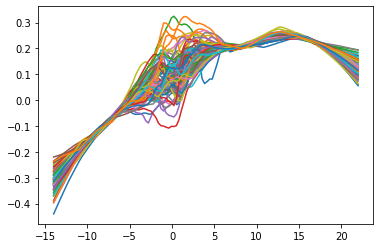

In [24]:
for pred in all_test_preds[:]:
    plt.plot(x_, pred[0, :, 0])

In [32]:
preds_concat = onp.concatenate(all_test_preds, axis=0)
# onp.save("synthreg_hmc_chain2.npy", preds_concat)

## SGLD

In [526]:
from bnn_hmc.core import sgmcmc

In [527]:
lr_schedule = train_utils.make_cosine_lr_schedule_with_burnin(3.e-8, 3.e-8, 1)
optimizer = sgmcmc.sgld_gradient_update(lr_schedule, 0)

In [528]:
param_seed = 0
params, net_state = net.init(jax.random.PRNGKey(param_seed), (f, None), True)
params = resample_params(param_seed, params, std=0.05)

In [529]:
sgmcmc_train_epoch = train_utils.make_sgd_train_epoch(
    net_apply, log_likelihood_fn, log_prior_fn, optimizer, num_batches=1)

In [530]:
num_iterations = 100000
all_test_preds = []
key = jax.random.PRNGKey(0)
key = jax.random.split(key, num_devices)
save_freq = 1000

for iteration in tqdm.tqdm(range(num_iterations)):
    params, net_state, opt_state, logprob_avg, key = sgmcmc_train_epoch(
        params, net_state, opt_state, train_set, key)
    if iteration % save_freq == 0:
        test_predictions = onp.asarray(
              predict_fn(net_apply, params, net_state, test_set))
        all_test_preds.append(test_predictions)

100%|██████████| 100000/100000 [02:42<00:00, 615.98it/s]


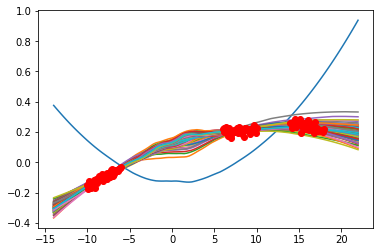

In [531]:
for pred in all_test_preds:#[::10][4:]:
    plt.plot(x_, pred[0, :, 0])
    
plt.plot(x, y, "ro")

In [532]:
preds_concat = onp.concatenate(all_test_preds, axis=0)
# onp.save("synthreg_sgld3e8.npy", preds_concat)

## SGHMC

In [26]:
from bnn_hmc.core import sgmcmc

In [27]:
lr = 1.e-8
mom = 0.95
lr_schedule = optim_utils.make_constant_lr_schedule_with_cosine_burnin(lr, lr, 1)
optimizer = sgmcmc.sgld_gradient_update(lr_schedule, momentum_decay=mom, seed=0)

In [28]:
param_seed = 0
params, net_state = net.init(jax.random.PRNGKey(param_seed), (f, None), True)
params = resample_params(param_seed, params, std=0.05)
opt_state = optimizer.init(params)

In [29]:
sgmcmc_train_epoch = train_utils.make_sgd_train_epoch(
    net_apply, log_likelihood_fn, log_prior_fn, optimizer, num_batches=1)

In [30]:
num_iterations = 100000
all_test_preds = []
key = jax.random.PRNGKey(0)
key = jax.random.split(key, num_devices)
save_freq = 1000

for iteration in tqdm.tqdm(range(num_iterations)):
    params, net_state, opt_state, logprob_avg, key = sgmcmc_train_epoch(
        params, net_state, opt_state, train_set, key)
    if iteration % save_freq == 0:
        test_predictions = onp.asarray(
              predict_fn(net_apply, params, net_state, test_set))
        all_test_preds.append(test_predictions)

100%|██████████| 100000/100000 [03:32<00:00, 471.36it/s]


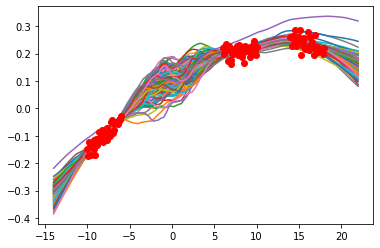

In [31]:
for pred in all_test_preds[2:]:#[::10][4:]:
    plt.plot(x_, pred[0, :, 0])
    
plt.plot(x, y, "ro")

In [33]:
preds_concat = onp.concatenate(all_test_preds, axis=0)
onp.save("synthreg_sghmc_lr{}_mom{}.npy".format(lr, mom), preds_concat)

## SGHMC with Cyclical  LR

In [93]:
from bnn_hmc.core import sgmcmc

In [94]:
lr = 3.e-8
mom = 0.95
burnin_len = 1000
cycle_len = 1000

lr_schedule = optim_utils.make_cyclical_cosine_lr_schedule_with_const_burnin(lr, burnin_len, cycle_len)
optimizer = sgmcmc.sgld_gradient_update(lr_schedule, momentum_decay=mom, preconditioner=None, seed=0)

In [95]:
param_seed = 0
params, net_state = net.init(jax.random.PRNGKey(param_seed), (f, None), True)
params = resample_params(param_seed, params, std=0.05)
opt_state = optimizer.init(params)

In [96]:
sgmcmc_train_epoch = train_utils.make_sgd_train_epoch(
    net_apply, log_likelihood_fn, log_prior_fn, optimizer, num_batches=1)

In [97]:
num_iterations = 100000
all_test_preds = []
key = jax.random.PRNGKey(0)
key = jax.random.split(key, num_devices)
lrs = []


for iteration in tqdm.tqdm(range(num_iterations)):
    params, net_state, opt_state, logprob_avg, key = sgmcmc_train_epoch(
        params, net_state, opt_state, train_set, key)
    
    lr = lr_schedule(opt_state.count)
    lrs.append(lr)
    if iteration > burnin_len and (iteration - burnin_len + 1) % cycle_len == 0:
#         print("lr:", lr)
        test_predictions = onp.asarray(
              predict_fn(net_apply, params, net_state, test_set))
        all_test_preds.append(test_predictions)

100%|██████████| 100000/100000 [07:07<00:00, 234.18it/s]


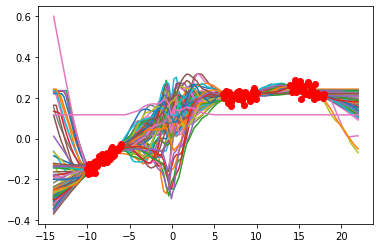

In [98]:
for pred in all_test_preds[2:]:#[::10][4:]:
    plt.plot(x_, pred[0, :, 0])
    
plt.plot(x, y, "ro")

In [99]:
preds_concat = onp.concatenate(all_test_preds, axis=0)
onp.save("synthreg_sghmc_cyclical_lr{}_mom{}.npy".format(lr, mom), preds_concat)

## SGHMC with PreConditioner

In [40]:
from bnn_hmc.core import sgmcmc

In [41]:
lr = 1.e-5
mom = 0.95
lr_schedule = optim_utils.make_constant_lr_schedule_with_cosine_burnin(lr, lr, 1)
preconditioner = sgmcmc.get_rmsprop_preconditioner()
optimizer = sgmcmc.sgld_gradient_update(lr_schedule, momentum_decay=mom, preconditioner=preconditioner, seed=0)

In [42]:
param_seed = 0
params, net_state = net.init(jax.random.PRNGKey(param_seed), (f, None), True)
params = resample_params(param_seed, params, std=0.05)
opt_state = optimizer.init(params)

In [43]:
sgmcmc_train_epoch = train_utils.make_sgd_train_epoch(
    net_apply, log_likelihood_fn, log_prior_fn, optimizer, num_batches=1)

In [44]:
num_iterations = 100000
all_test_preds = []
key = jax.random.PRNGKey(0)
key = jax.random.split(key, num_devices)
save_freq = 1000

for iteration in tqdm.tqdm(range(num_iterations)):
    params, net_state, opt_state, logprob_avg, key = sgmcmc_train_epoch(
        params, net_state, opt_state, train_set, key)
    if iteration % save_freq == 0:
        test_predictions = onp.asarray(
              predict_fn(net_apply, params, net_state, test_set))
        all_test_preds.append(test_predictions)

100%|██████████| 100000/100000 [04:27<00:00, 373.72it/s]


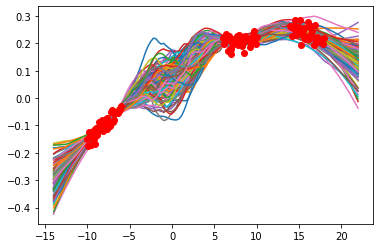

In [45]:
for pred in all_test_preds[2:]:#[::10][4:]:
    plt.plot(x_, pred[0, :, 0])
    
plt.plot(x, y, "ro")

In [46]:
preds_concat = onp.concatenate(all_test_preds, axis=0)
onp.save("synthreg_sghmc_rmsprop_lr{}_mom{}.npy".format(lr, mom), preds_concat)

## SGHMC with PreConditioner with Cyclical  LR

In [59]:
from bnn_hmc.core import sgmcmc

In [60]:
lr = 1.e-4
mom = 0.95
burnin_len = 1000
cycle_len = 1000

lr_schedule = optim_utils.make_cyclical_cosine_lr_schedule_with_const_burnin(lr, burnin_len, cycle_len)
preconditioner = sgmcmc.get_rmsprop_preconditioner()
optimizer = sgmcmc.sgld_gradient_update(lr_schedule, momentum_decay=mom, preconditioner=preconditioner, seed=0)

In [61]:
param_seed = 0
params, net_state = net.init(jax.random.PRNGKey(param_seed), (f, None), True)
params = resample_params(param_seed, params, std=0.05)
opt_state = optimizer.init(params)

In [62]:
sgmcmc_train_epoch = train_utils.make_sgd_train_epoch(
    net_apply, log_likelihood_fn, log_prior_fn, optimizer, num_batches=1)

In [63]:
num_iterations = 100000
all_test_preds = []
key = jax.random.PRNGKey(0)
key = jax.random.split(key, num_devices)
lrs = []


for iteration in tqdm.tqdm(range(num_iterations)):
    params, net_state, opt_state, logprob_avg, key = sgmcmc_train_epoch(
        params, net_state, opt_state, train_set, key)
    
    lr = lr_schedule(opt_state.count)
    lrs.append(lr)
    if iteration > burnin_len and (iteration - burnin_len + 1) % cycle_len == 0:
#         print("lr:", lr)
        test_predictions = onp.asarray(
              predict_fn(net_apply, params, net_state, test_set))
        all_test_preds.append(test_predictions)

100%|██████████| 100000/100000 [07:41<00:00, 216.74it/s]


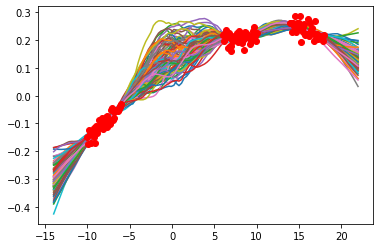

In [68]:
for pred in all_test_preds[2:]:#[::10][4:]:
    plt.plot(x_, pred[0, :, 0])
    
plt.plot(x, y, "ro")

In [69]:
preds_concat = onp.concatenate(all_test_preds, axis=0)
onp.save("synthreg_sghmc_rmsprop_cyclical_lr{}_mom{}.npy".format(lr, mom), preds_concat)

## SGD

In [119]:
# prior_std = .1
# weight_decay = 1 / prior_std**2

# log_prior_fn, log_prior_diff_fn = losses.make_gaussian_log_prior(weight_decay, 1.)

In [120]:
net_fn = make_model(layer_dims=[100, 100, 100], invsp_noise_std=invsp_noise_std)
net = hk.transform_with_state(net_fn)
net_apply, net_init = net.apply, net.init
net_apply = precision_utils.rewrite_high_precision(net_apply)

In [121]:
num_iterations = 1000

In [122]:
lr_schedule = optim_utils.make_cosine_lr_schedule(1e-7, num_iterations)
optimizer = optim_utils.make_sgd_optimizer(lr_schedule, momentum_decay=0.9)

In [123]:
sgd_train_epoch = train_utils.make_sgd_train_epoch(
    net_apply, log_likelihood_fn, log_prior_fn, optimizer, num_batches=1)

In [124]:
param_seed = 2
params, net_state = net.init(jax.random.PRNGKey(param_seed), (f, None), True)
params = resample_params(param_seed, params, std=0.05)
net_state = jax.pmap(lambda _: net_state)(jnp.arange(num_devices))
opt_state = optimizer.init(params)

In [125]:
key = jax.random.PRNGKey(0)
key = jax.random.split(key, num_devices)

for iteration in tqdm.tqdm(range(num_iterations)):
    params, net_state, opt_state, logprob_avg, key = sgd_train_epoch(
        params, net_state, opt_state, train_set, key)

100%|██████████| 1000/1000 [00:02<00:00, 378.62it/s]


In [126]:
_, test_predictions = onp.asarray(
    predict_fn(net_apply, params, net_state, test_set))

/home/pavel/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


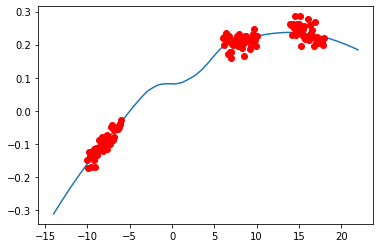

In [127]:
plt.plot(x_, test_predictions[0, :, 0])
plt.plot(x, y, "ro")

In [59]:
checkpoint_utils.save_checkpoint("synthreg_sgd_params.pt", {"params": params})

## VI

In [385]:
sgd_params = checkpoint_utils.load_checkpoint("synthreg_sgd_params.pt")["params"]

In [386]:
def get_mfvi_model_fn(net_fn, params, net_state, seed=0, sigma_init=0.):
    #  net_fn(params, net_state, None, batch, is_training)
    mean_params = jax.tree_map(lambda p: p.copy(), params)
    std_params = jax.tree_map(lambda p: jnp.ones_like(p) * sigma_init, params)
    mfvi_params = {"mean": mean_params, "inv_softplus_std": std_params}
    mfvi_state = {"net_state": copy.deepcopy(net_state), 
                  "mfvi_key": jax.random.PRNGKey(seed)}
    
    def mfvi_apply_fn(params, state, _, batch, is_training):
        mean = params["mean"]
        std = jax.tree_map(jax.nn.softplus, params["inv_softplus_std"])
        noise, new_key = tree_utils.normal_like_tree(mean, state["mfvi_key"])
        params_sampled = jax.tree_multimap(lambda m, s, n: m + n * s, mean, std, noise)
        predictions, new_net_state = net_fn(params_sampled, state["net_state"], None, batch, is_training)
        new_mfvi_state = {"net_state": copy.deepcopy(new_net_state), 
                          "mfvi_key": new_key}
        return predictions, new_mfvi_state
    
    return mfvi_apply_fn, mfvi_params, mfvi_state, 

In [387]:
def make_elbo_gaussian_log_prior(weight_decay, temperature):
    def log_prior(params):
        n_params = sum([p.size for p in jax.tree_leaves(params)])
        sigma_prior = jnp.sqrt(1 / weight_decay)
        
        mu_vi_tree = params["mean"]
        sigma_vi_tree = jax.tree_map(jax.nn.softplus, params["inv_softplus_std"])
        
        def get_parameter_kl(mu_vi, sigma_vi):
            return (jnp.log(sigma_prior / sigma_vi) + 
                    (sigma_vi**2 + mu_vi**2) / 2 / sigma_prior**2 - 1 / 2)
        
        kl_tree = jax.tree_multimap(get_parameter_kl, mu_vi_tree, sigma_vi_tree)
        kl = sum([p_kl.sum() for p_kl in jax.tree_leaves(kl_tree)])

        return -kl / temperature
  
    def log_prior_diff(params1, params2):
        raise NotImplementedError


    return log_prior, log_prior_diff


def fake_likelihood(net_apply, params, net_state, batch, is_training):
    return jnp.zeros(()), net_state

In [388]:
net_fn = make_model(layer_dims=[100, 100, 100], invsp_noise_std=invsp_noise_std)
net = hk.transform_with_state(net_fn)
net_apply, net_init = net.apply, net.init
net_apply = precision_utils.rewrite_high_precision(net_apply)
_, net_state = net.init(jax.random.PRNGKey(param_seed), (f, None), True)

net_apply, params, net_state = get_mfvi_model_fn(net_apply, sgd_params, net_state, sigma_init=-3.)
net_state = jax.pmap(lambda _: net_state)(jnp.arange(num_devices))

In [389]:
num_iterations = 10000
lr_schedule = optim_utils.make_cosine_lr_schedule(1e-3, num_iterations)
optimizer = optim_utils.make_adam_optimizer(lr_schedule)
opt_state = optimizer.init(params)

In [390]:
vi_log_prior_fn, _ = make_elbo_gaussian_log_prior(weight_decay, 1.)
sgd_train_epoch = train_utils.make_sgd_train_epoch(
    net_apply, log_likelihood_fn, vi_log_prior_fn, optimizer, num_batches=1)
# sgd_train_epoch = train_utils.make_sgd_train_epoch(
#     net_apply, fake_likelihood, vi_log_prior_fn, optimizer, num_batches=1)

In [391]:

key = jax.random.PRNGKey(0)
key = jax.random.split(key, num_devices)

for iteration in tqdm.tqdm(range(num_iterations)):
    params, net_state, opt_state, logprob_avg, key = sgd_train_epoch(
        params, net_state, opt_state, train_set, key)

100%|██████████| 10000/10000 [00:46<00:00, 217.27it/s]


In [392]:
_, all_test_preds = jax.lax.scan(
    lambda state, _: predict_fn(net_apply, params, state, test_set), 
    init=net_state,
    xs=jnp.arange(10))

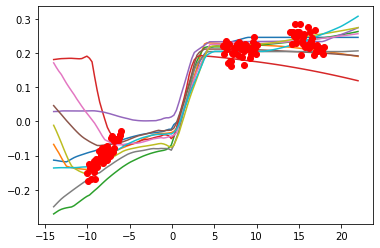

In [394]:
for pred in all_test_preds:#[::10][4:]:
    plt.plot(x_, pred[0, :, 0])
    
plt.plot(x, y, "ro")

In [374]:
net_state

{'mfvi_key': ShardedDeviceArray([[2490749004, 2000077409]], dtype=uint32),
 'net_state': FlatMapping({})}